The cross comparison method is proposed by Woz: https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17

In [1]:
import pandas as pd
from pathlib import Path

dfs = []

for file in Path("./raw").glob("*.csv"):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
df.rename(columns={"R (SM17)": "R (SM-17)"}, inplace=True)
df.rename(columns={"R (SM16)": "R (SM-16)"}, inplace=True)
df.head()

,y,R (SM-16),R (SM-17),R (AVG),R (MOVING-AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
0,1,0.841,0.866,0.641176,0.613784,0.720,0.545,0.640,0.603,0.660
1,1,0.684,0.548,0.557143,0.640863,0.464,0.340,0.478,0.444,0.582
2,1,0.698,0.667,0.900000,0.665267,0.464,0.340,0.478,0.444,0.582
3,1,0.810,0.981,0.593333,0.707050,0.730,0.503,0.654,0.622,0.740
4,1,0.796,0.916,0.595000,0.578715,0.645,0.474,0.585,0.548,0.633


In [2]:
df.describe()

,y,R (SM-16),R (SM-17),R (AVG),R (MOVING-AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
count,652278.000000,652278.000000,652278.000000,652278.000000,652278.000000,652278.000000,652278.000000,652278.000000,652278.000000,652278.000000
mean,0.869229,0.854864,0.886326,0.867499,0.864028,0.833819,0.839955,0.846337,0.845234,0.855837
std,0.337150,0.145658,0.127711,0.056096,0.086665,0.165922,0.152060,0.133504,0.134621,0.095522
min,0.000000,0.005000,0.000000,0.064286,0.134825,0.000000,0.004000,0.031000,0.031000,0.207000
25%,1.000000,0.822000,0.847000,0.837004,0.826541,0.797000,0.796000,0.798000,0.797000,0.810000
50%,1.000000,0.905000,0.912000,0.880738,0.880813,0.886000,0.888000,0.886000,0.885000,0.876000
75%,1.000000,0.945000,0.982000,0.903901,0.921979,0.937000,0.941000,0.939000,0.939000,0.924000
max,1.000000,0.999000,1.000000,0.996970,0.997495,1.000000,1.000000,1.000000,1.000000,1.000000


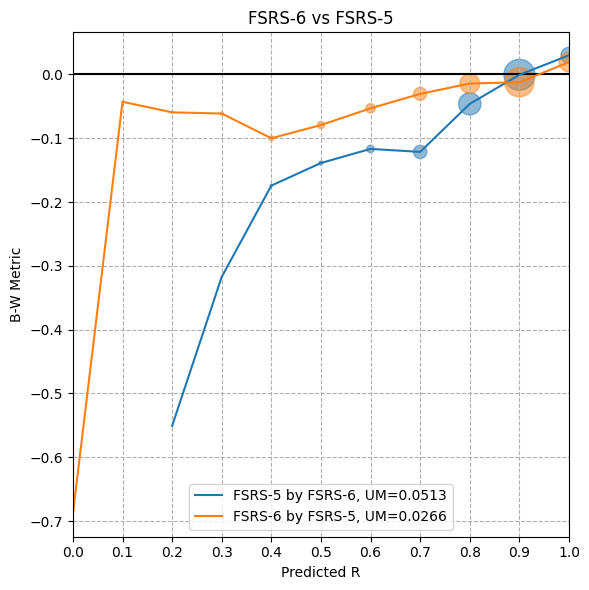

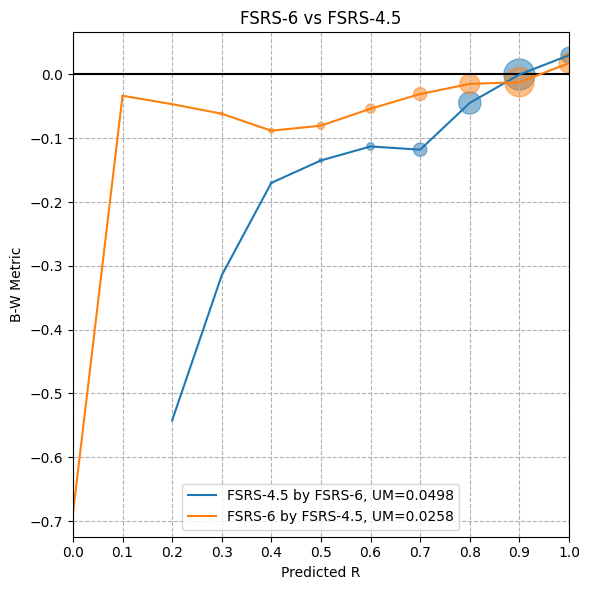

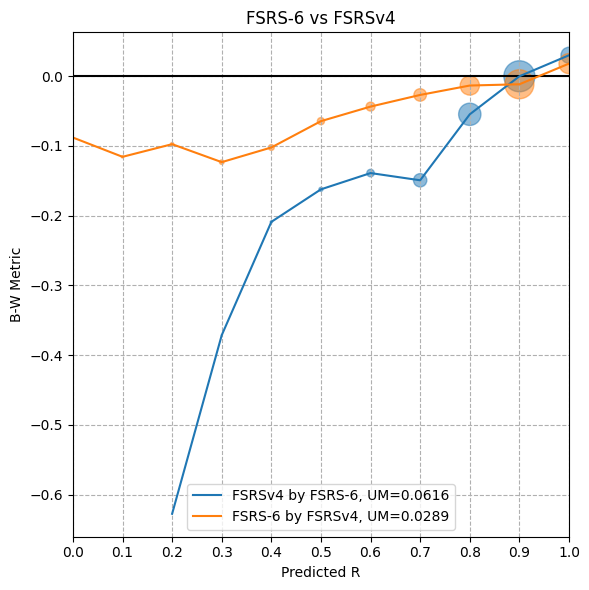

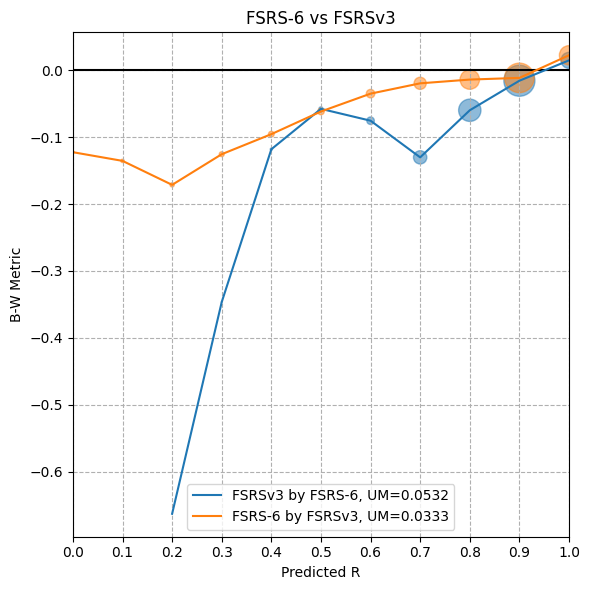

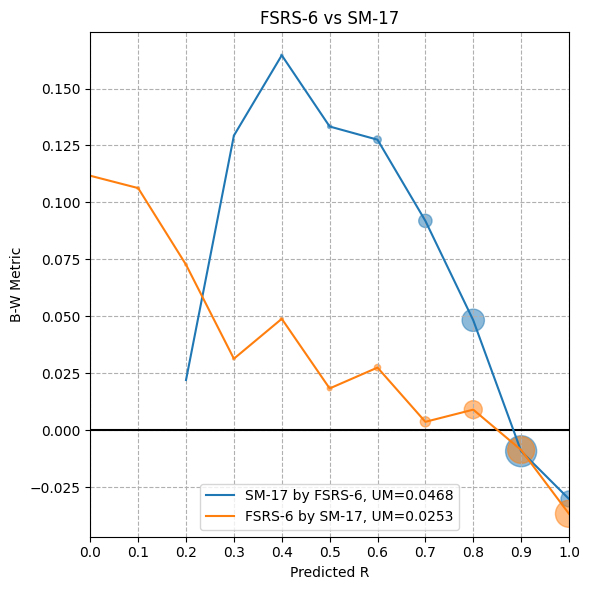

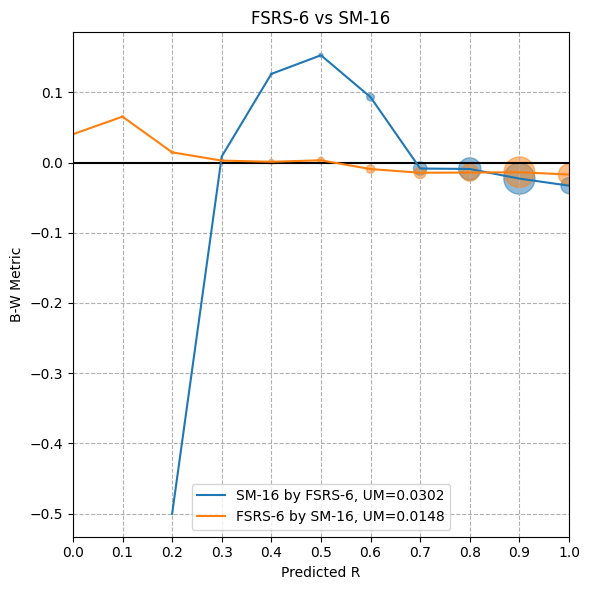

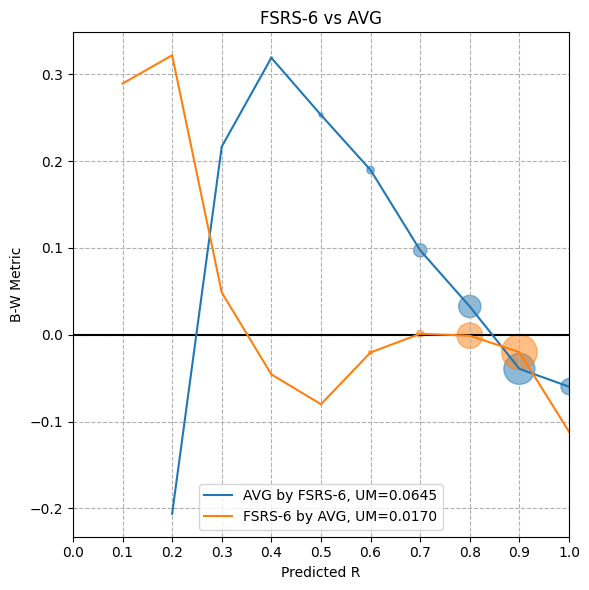

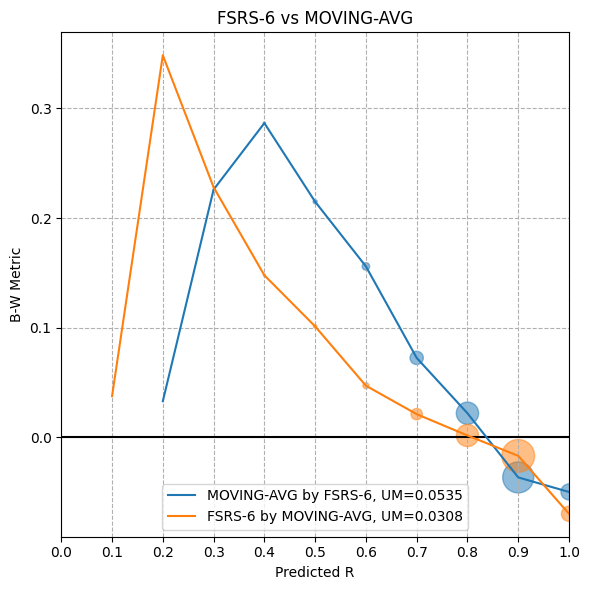

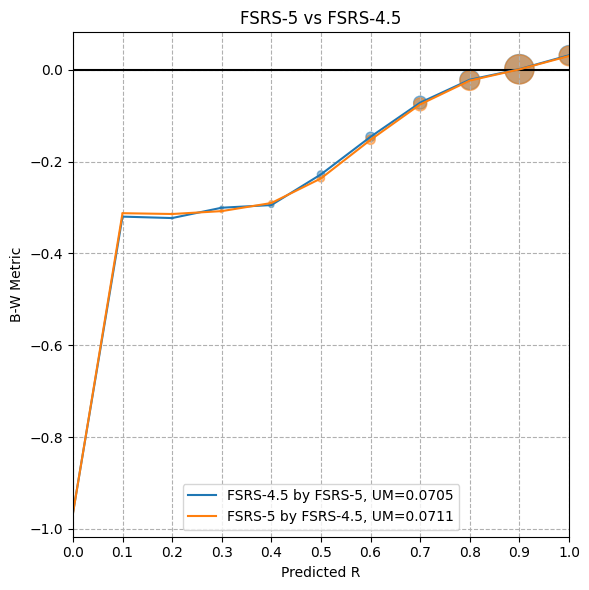

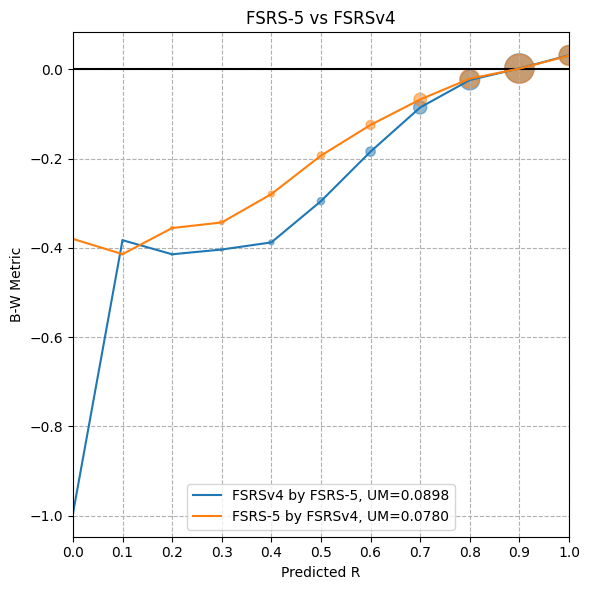

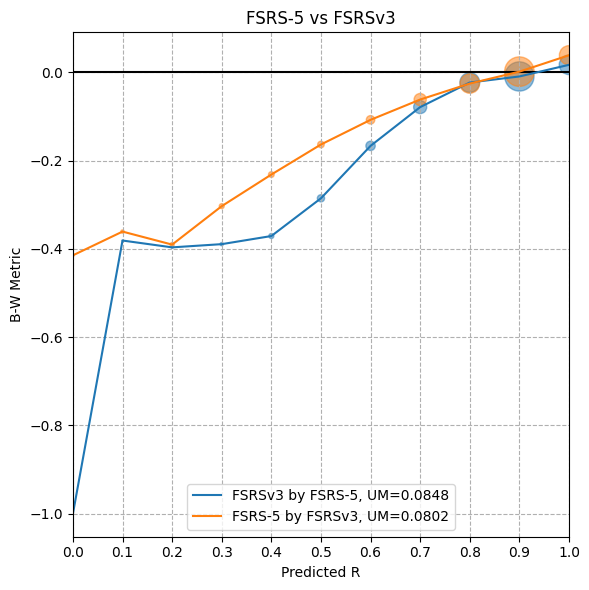

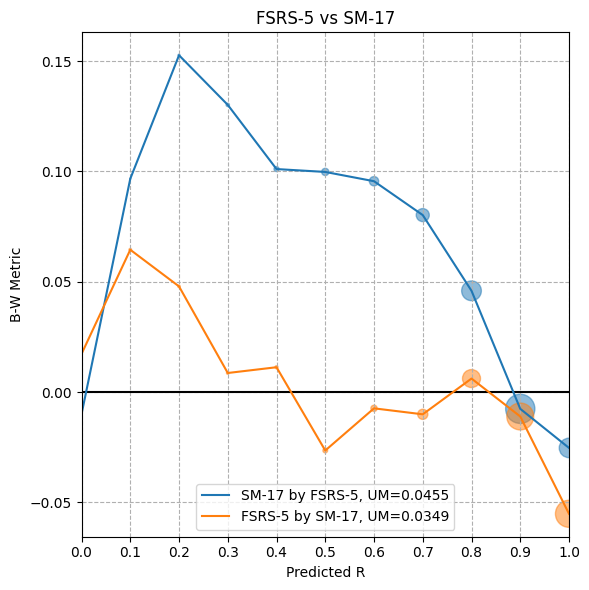

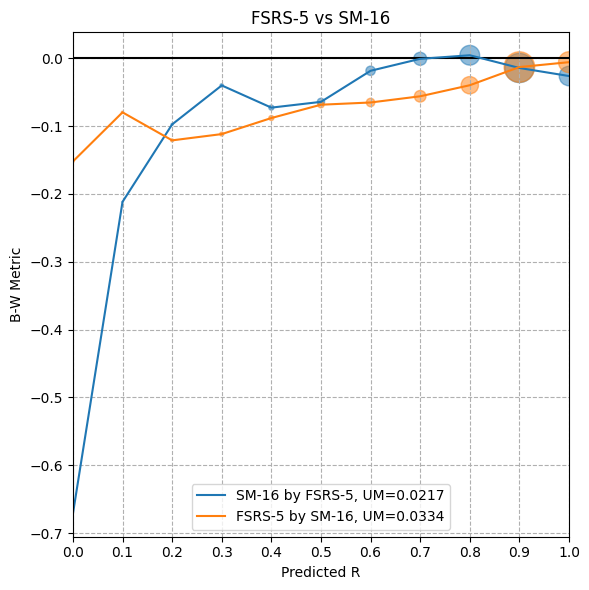

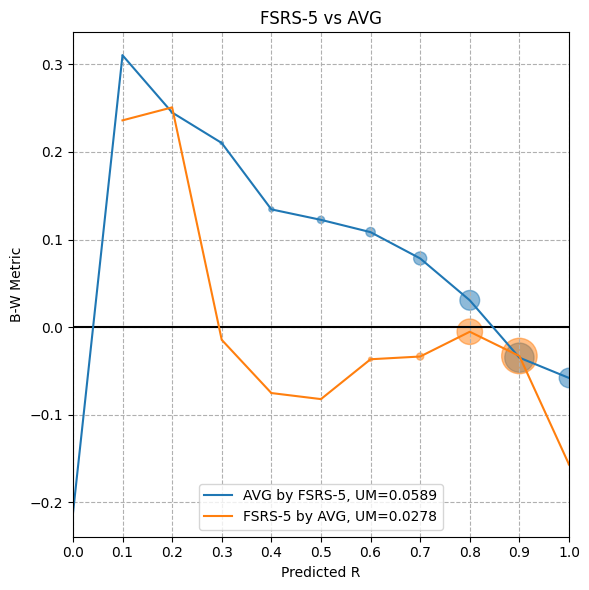

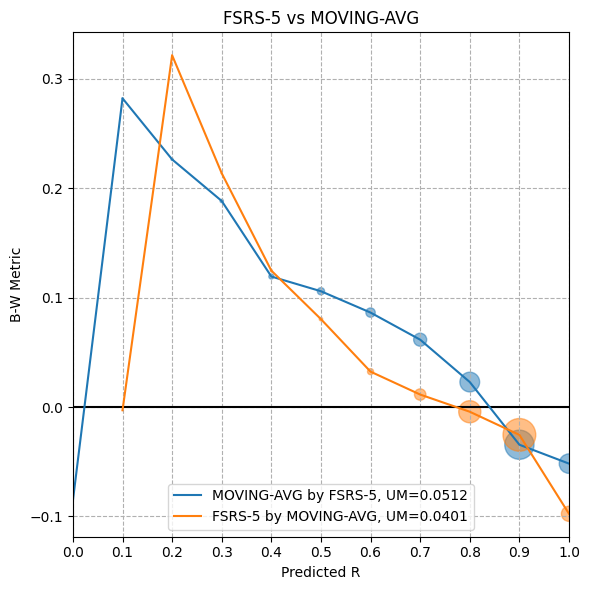

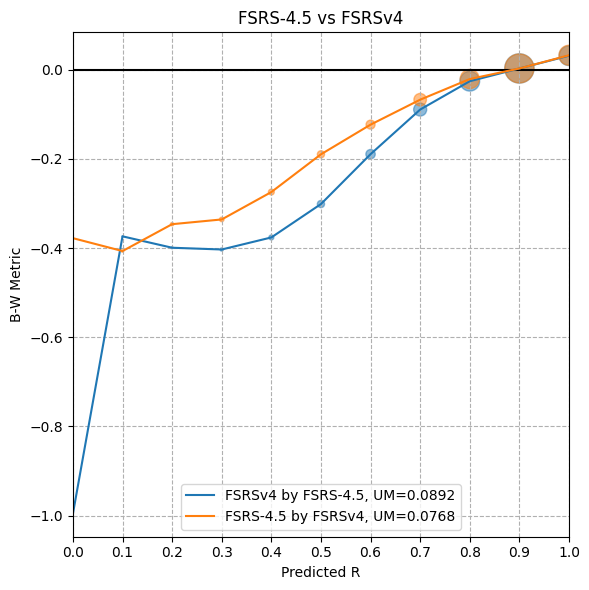

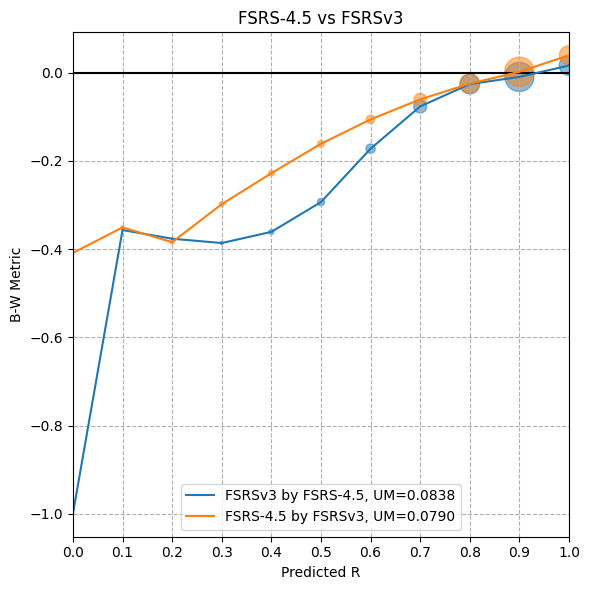

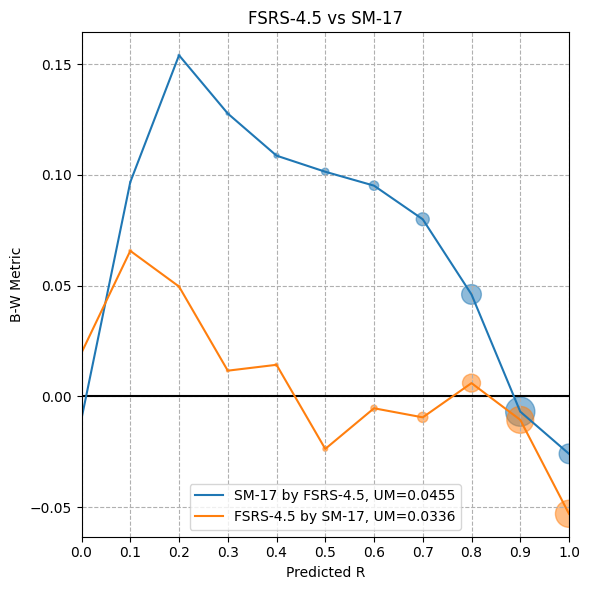

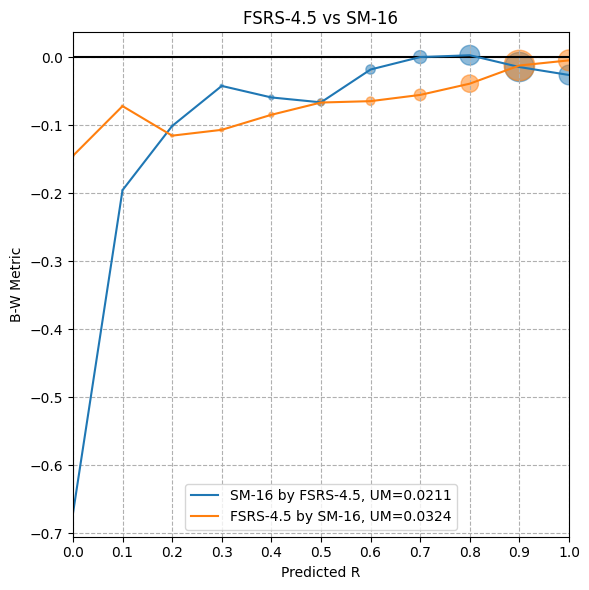

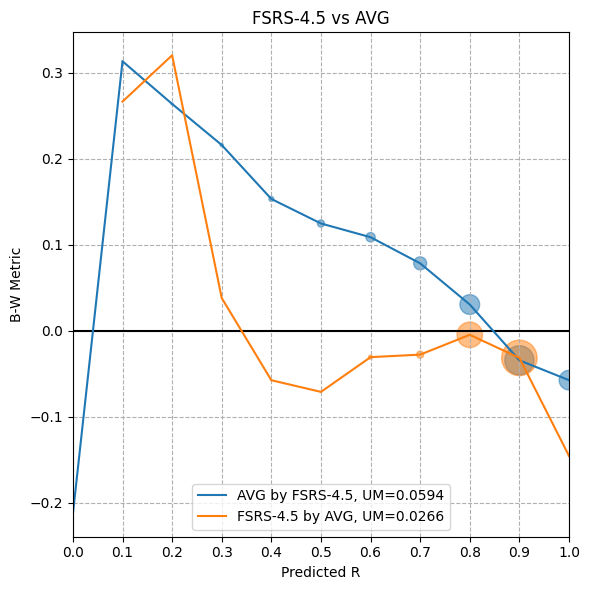

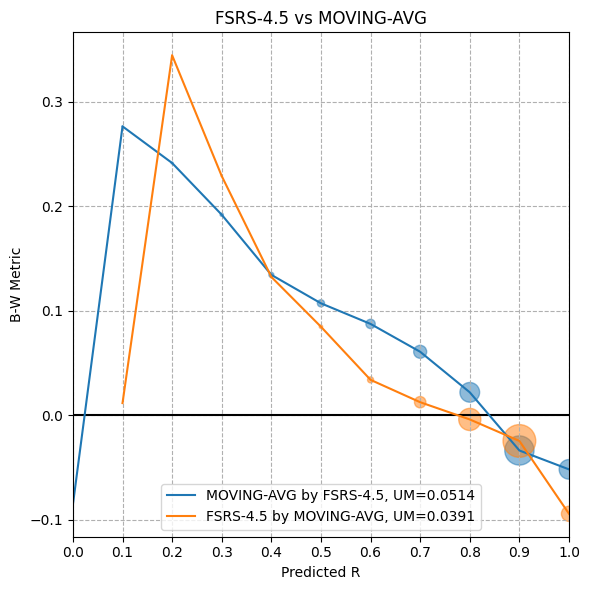

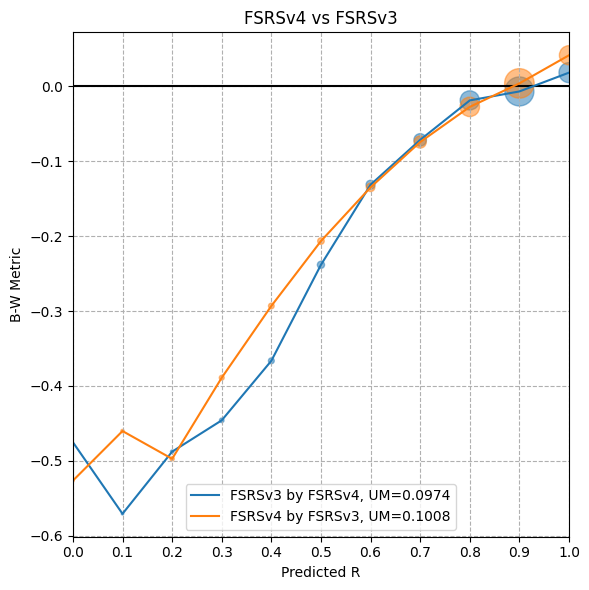

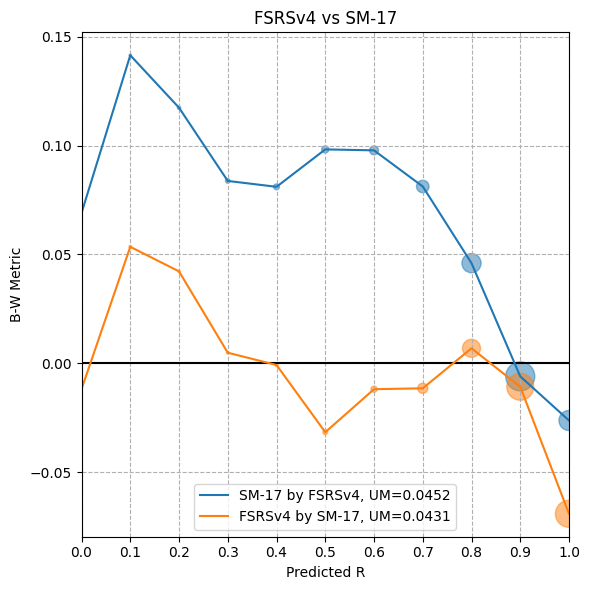

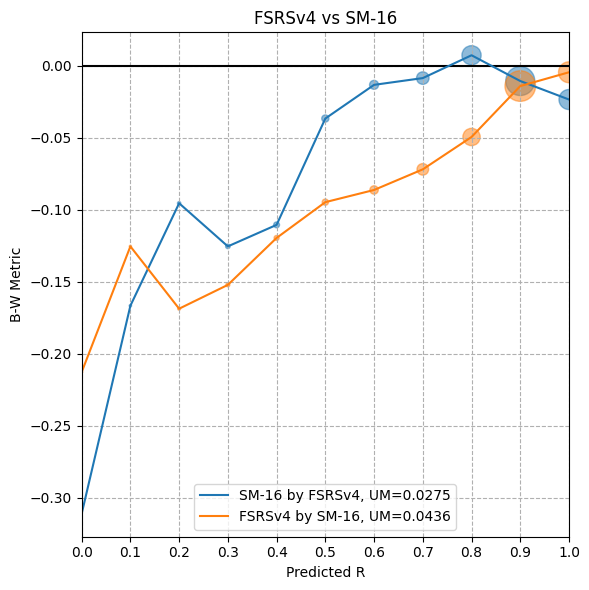

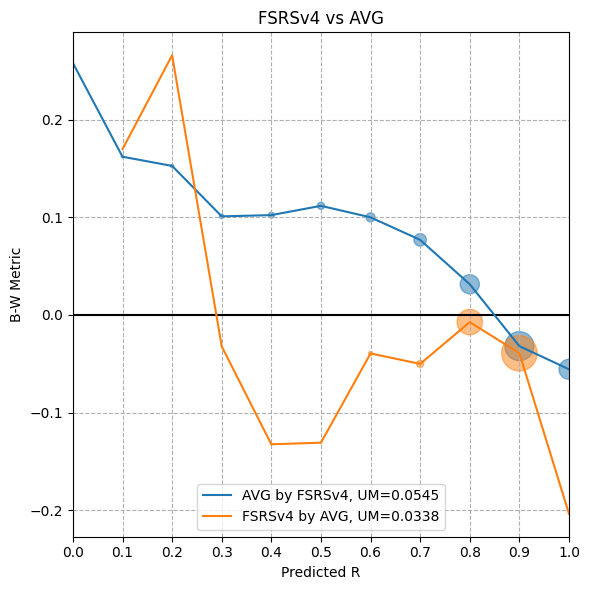

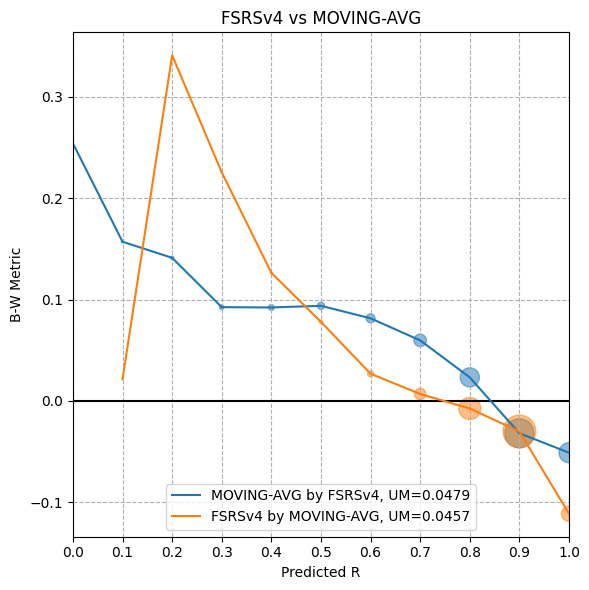

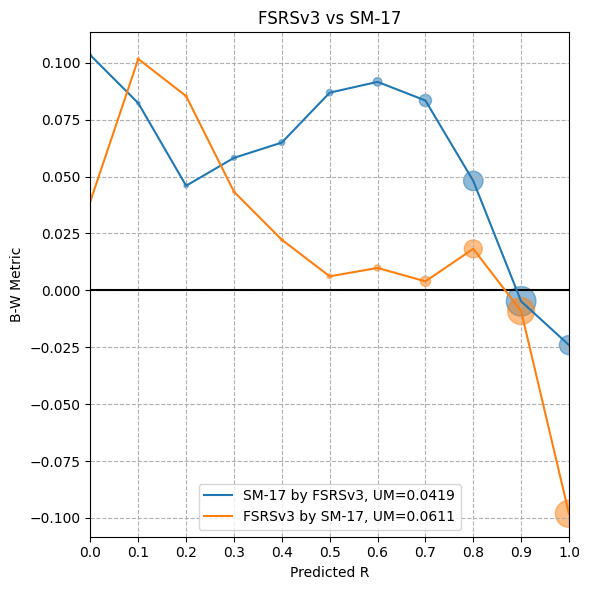

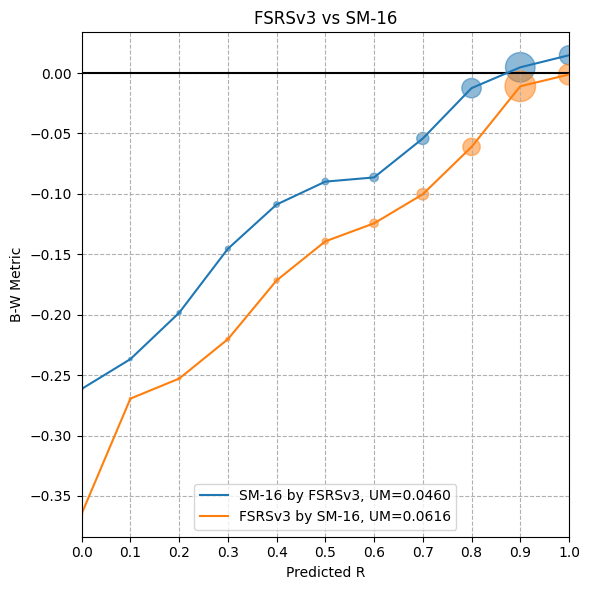

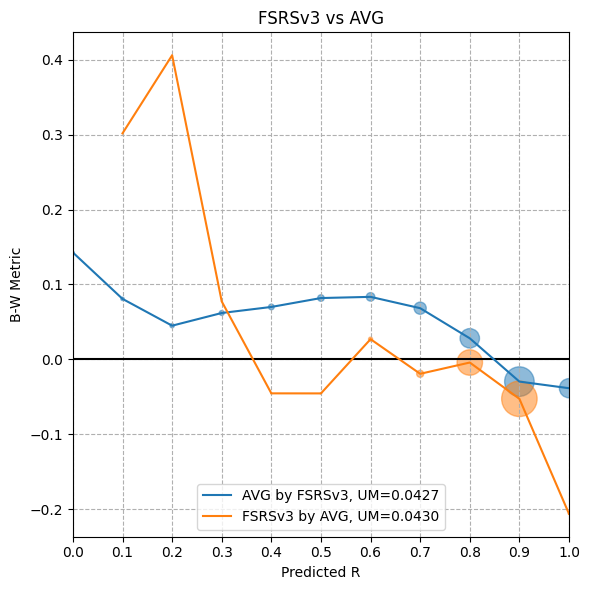

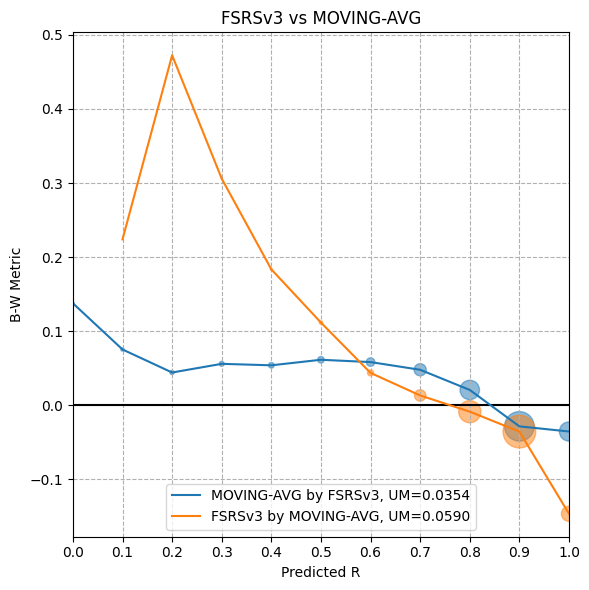

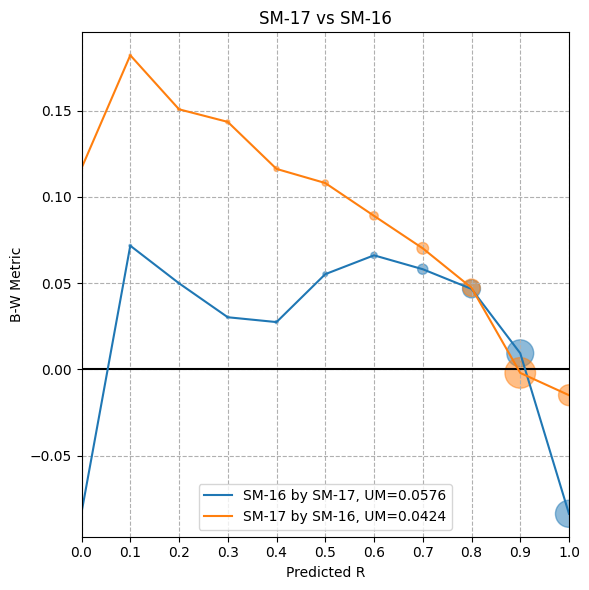

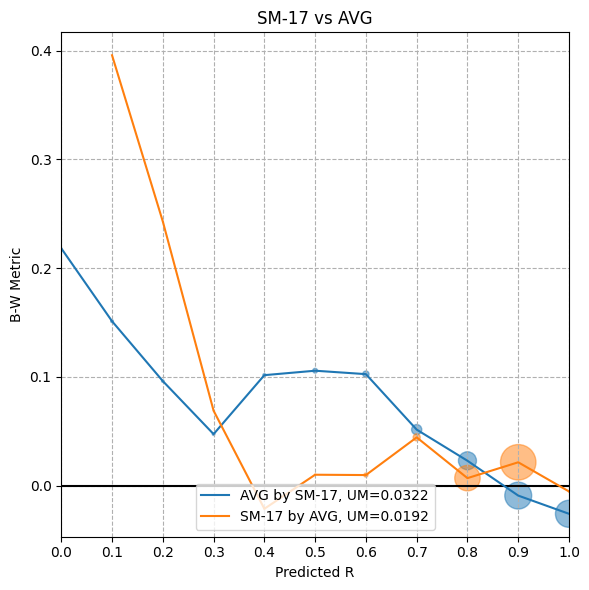

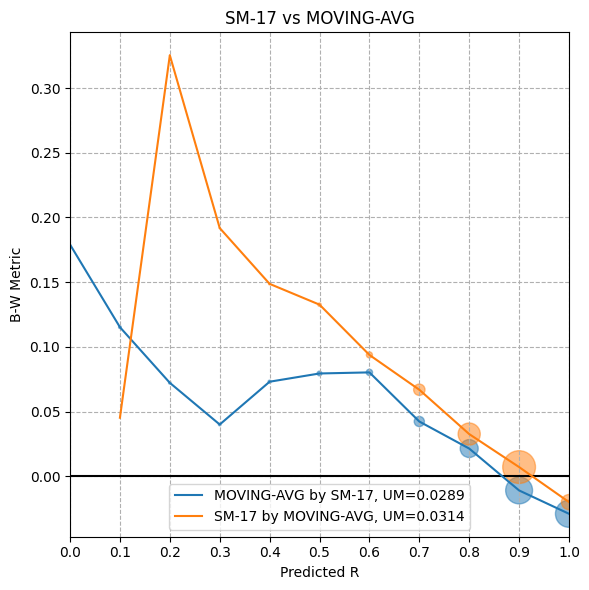

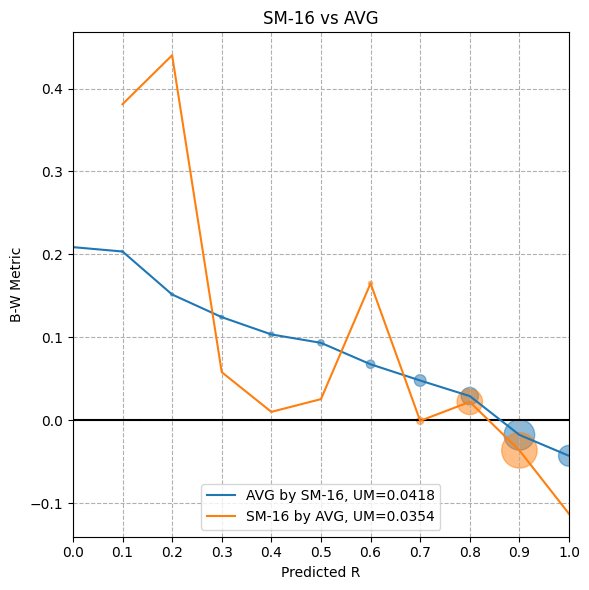

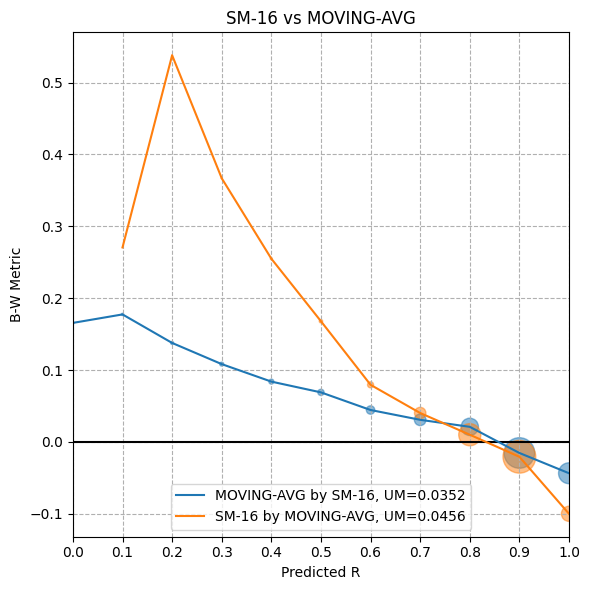

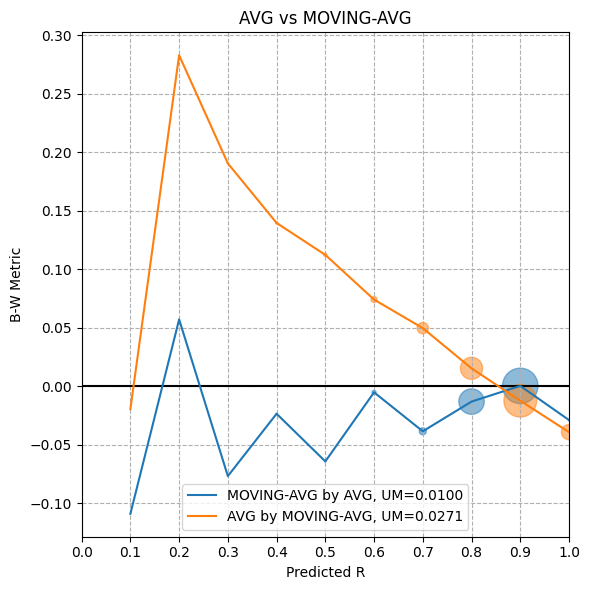

[{'FSRS-5_evaluated_by_FSRS-6': 0.0513, 'FSRS-6_evaluated_by_FSRS-5': 0.0266},
 {'FSRS-4.5_evaluated_by_FSRS-6': 0.0498,
  'FSRS-6_evaluated_by_FSRS-4.5': 0.0258},
 {'FSRSv4_evaluated_by_FSRS-6': 0.0616, 'FSRS-6_evaluated_by_FSRSv4': 0.0289},
 {'FSRSv3_evaluated_by_FSRS-6': 0.0532, 'FSRS-6_evaluated_by_FSRSv3': 0.0333},
 {'SM-17_evaluated_by_FSRS-6': 0.0468, 'FSRS-6_evaluated_by_SM-17': 0.0253},
 {'SM-16_evaluated_by_FSRS-6': 0.0302, 'FSRS-6_evaluated_by_SM-16': 0.0148},
 {'AVG_evaluated_by_FSRS-6': 0.0645, 'FSRS-6_evaluated_by_AVG': 0.017},
 {'MOVING-AVG_evaluated_by_FSRS-6': 0.0535,
  'FSRS-6_evaluated_by_MOVING-AVG': 0.0308},
 {'FSRS-4.5_evaluated_by_FSRS-5': 0.0705,
  'FSRS-5_evaluated_by_FSRS-4.5': 0.0711},
 {'FSRSv4_evaluated_by_FSRS-5': 0.0898, 'FSRS-5_evaluated_by_FSRSv4': 0.078},
 {'FSRSv3_evaluated_by_FSRS-5': 0.0848, 'FSRS-5_evaluated_by_FSRSv3': 0.0802},
 {'SM-17_evaluated_by_FSRS-5': 0.0455, 'FSRS-5_evaluated_by_SM-17': 0.0349},
 {'SM-16_evaluated_by_FSRS-5': 0.0217, 'FSRS

In [3]:
from utils import cross_comparison
import itertools

results = []

all_algorithms = ["FSRS-6", "FSRS-5", "FSRS-4.5", "FSRSv4", "FSRSv3", "SM-17", "SM-16", "AVG", "MOVING-AVG"]

for player, referee in itertools.combinations(all_algorithms, 2):
    results.append(cross_comparison(df, player, referee))
results

In [4]:
import numpy as np

final_results = {}

for player in all_algorithms:
    universal_metrics = []
    for result in results:
        for key, value in result.items():
            if key.startswith(player):
                universal_metrics.append(value)
    final_results[player] = np.array(universal_metrics).mean().round(4)

# Sort by value (ascending, lower is better)
sorted_results = sorted(final_results.items(), key=lambda x: x[1])

# Display result in markdown table format, bold the best algorithm and its metric
print("| Algorithm | Universal Metric↓ |")
print("|-----------|------------------|")
for i, (algo, metric) in enumerate(sorted_results):
    if i == 0:
        print(f"| **{algo}** | **{metric:.4f}** |")
    else:
        print(f"| {algo} | {metric:.4f} |")

| Algorithm | Universal Metric↓ |
|-----------|------------------|
| **FSRS-6** | **0.0253** |
| SM-16 | 0.0356 |
| MOVING-AVG | 0.0392 |
| SM-17 | 0.0397 |
| AVG | 0.0476 |
| FSRS-4.5 | 0.0510 |
| FSRS-5 | 0.0521 |
| FSRSv4 | 0.0635 |
| FSRSv3 | 0.0680 |
